### Zillow Home Price Examination

### Goal: 
      Discover drivers of house pricing.
      Use the drivers to develop a model classifying custmers who are
        most likely to churn

# Imports
    

First we'll start with importing the libraries that we need to perform 
our cleaning, prep, analysis other steps will proceed

In [1]:
import os
import subprocess    
import acquireRegchopCopy1 as ac

import numpy as np
import pandas as pd
import numpy.ma as ma

import env
import scipy
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn import neighbors
from sklearn.metrics import mean_squared_error 
from math import sqrt

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from matplotlib import rcParams

# ignore warnings
import warnings
warnings.filterwarnings("ignore")



# Data Dictionary


# Acquire

Data came from zillow when they initiated a contest to see if it would be possible to crowdsource an improvement to their home value estimator - zestimate. The winner of the contest improved the zestimate by approximately 12%.

Here we load the dataset and set it to df so it can be referenced later

In [2]:
df = ac.get_zillow_data() #Where it actually happens

In [3]:
#df.count()

Data was downloaded from the codeup database Nov 22, 2022. Approximately 2.9 million rows with up to 59 datapoints for each observation. Some variables are missing most of the data though so dropping entire categories may be needed. 

# Prepare 

-First we drop any columns with a large amount of missing data, typically anything missing 70% or more of the data

-Removing unreasonable outcomes like having 0 beds or baths, and sqft over 20,000 (this still might be too high)

-We also remove any null values stored as white space

-Any variables that have values which aren't numerical or boolean get converted/codified

-If there are plavc where data is duplicated or generally represented by other columns (many of the pool trackers for example) we will drop those column

Now we should be able to call the function that makes all those changes 

In [4]:
df = ac.prep_zillow_data(df) 

In [5]:
df.describe()

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount
count,2.811396e+06,2.811396e+06,2.811396e+06,2.811396e+06,2.811396e+06,2.811396e+06
mean,3.198398e+00,2.265506e+00,1.757302e+03,3.929555e+05,2.009694e+03,4.857693e+03
std,1.090925e+00,9.239133e-01,8.026290e+02,3.011816e+05,5.112682e+01,3.521620e+03
min,1.000000e+00,5.000000e-01,1.000000e+00,2.200000e+01,1.875000e+03,1.257000e+01
25%,3.000000e+00,2.000000e+00,1.213000e+03,1.915170e+05,1.950000e+03,2.528560e+03
50%,3.000000e+00,2.000000e+00,1.566000e+03,3.200000e+05,1.963000e+03,4.008880e+03
75%,4.000000e+00,3.000000e+00,2.100000e+03,5.029750e+05,1.981000e+03,6.117385e+03
max,1.000000e+01,1.500000e+01,1.946000e+04,1.999995e+06,2.016000e+03,1.003793e+05


### Once the data is acquired and prepared, we can split it into our 3 groups for classification, then into X/Y split where we pull the target variable into its own group.

In [6]:
train, validate, test = ac.split_zillow_data(df)

In [7]:
x_train, y_train, x_validate, y_validate, x_test, y_test = ac.zsplit(train, validate, test)

# Explore / Questions:

In [8]:
train.describe()  #We can look at some basic information and categories

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,taxvaluedollarcnt,yearbuilt,taxamount
count,1.574381e+06,1.574381e+06,1.574381e+06,1.574381e+06,1.574381e+06,1.574381e+06
mean,3.197481e+00,2.265002e+00,1.756949e+03,3.927124e+05,1.982141e+03,4.854604e+03
std,1.086256e+00,9.268220e-01,8.037222e+02,3.010670e+05,2.947722e+01,3.519736e+03
min,1.000000e+00,5.000000e-01,1.000000e+00,2.200000e+01,1.875000e+03,1.257000e+01
25%,3.000000e+00,2.000000e+00,1.212000e+03,1.915290e+05,1.950000e+03,2.528200e+03
50%,3.000000e+00,2.000000e+00,1.565000e+03,3.199810e+05,1.963000e+03,4.007520e+03
75%,4.000000e+00,3.000000e+00,2.098000e+03,5.025480e+05,1.981000e+03,6.112370e+03
max,1.000000e+01,1.500000e+01,1.870800e+04,1.999995e+06,2.016000e+03,9.077906e+04


### How strongly does Total Squarefeet impact final value of a home?


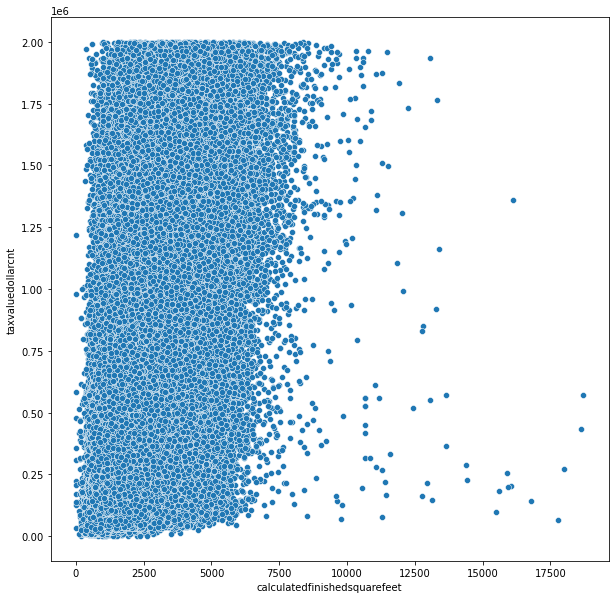

In [9]:
ac.getfirstplot(train)

### Above Figure: This plot shows that 

In [10]:
scipy.stats.pearsonr(train.calculatedfinishedsquarefeet, train.taxvaluedollarcnt)


(0.5608935115416793, 0.0)

The p value is indicative of correlation in the value of a home and its size in square feet. 

### What location has the highest mean value for homes and how strong is that correlation?

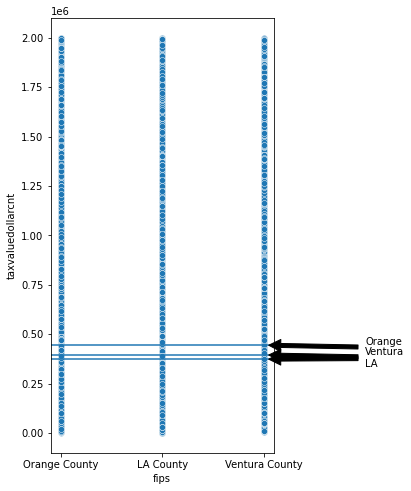

In [11]:
ac.getsecondplot(train)

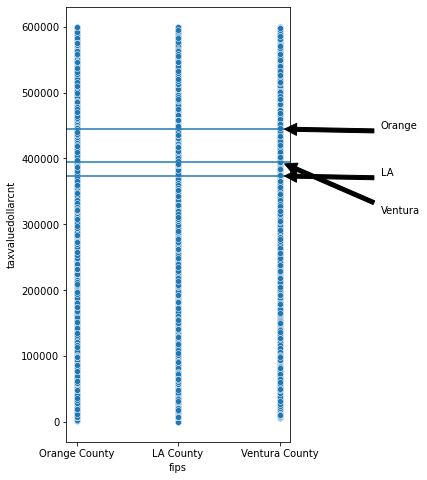

In [12]:
ac.cuffedplot(train)

### Above Figure: There seems to be a possible correlation here, but there may just be outliers, or a large difference in the number of properties. 

We'll use CI of 95% and a = .05

In [13]:
firstblock = train.taxvaluedollarcnt.where(train.fips == 'Ventura County')
firstblock = firstblock.dropna()

secondblock = train.taxvaluedollarcnt.where(train.fips == 'Orange County')
secondblock = secondblock.dropna()

thirdblock = train.taxvaluedollarcnt.where(train.fips == 'LA County')
thirdblock = thirdblock.dropna()

scipy.stats.kruskal(firstblock, secondblock, thirdblock)

KruskalResult(statistic=25862.953568039473, pvalue=0.0)

The p value indicates that there is significance in the variance of the means of the three counties. 

### What is the stronger influence? Bedrooms or bathrooms?


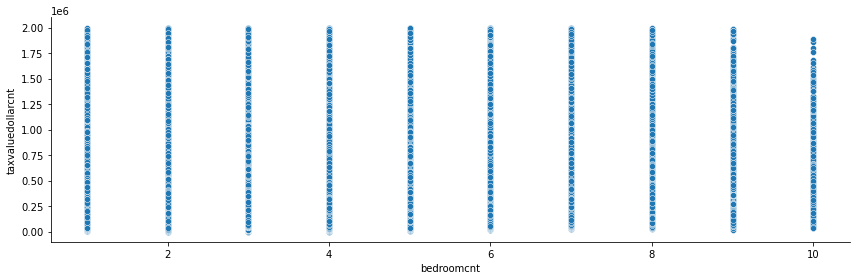

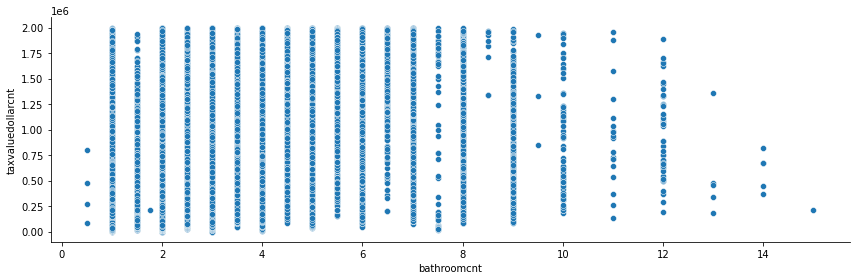

In [14]:
ac.getthirdplot(train)

sklearn.linear_model.LinearRegression(### With the above graphic we see that 


In [15]:
x_validate.bedroomcnt

283770     3.0
1171323    2.0
110984     2.0
1588994    3.0
407955     2.0
          ... 
629873     3.0
1034278    3.0
1557028    3.0
195544     3.0
2266338    3.0
Name: bedroomcnt, Length: 674735, dtype: float32

In [16]:
scipy.stats.spearmanr(x_train.bedroomcnt, y_train)

SpearmanrResult(correlation=0.25468098389721133, pvalue=0.0)

In [17]:
scipy.stats.spearmanr(x_train.bathroomcnt,y_train)

SpearmanrResult(correlation=0.4378984305568257, pvalue=0.0)

In [18]:
'''
def get_reg(x_train, x_validate, y_train, y_validate):
    x_train = x_train['fips'].replace(['Ventura County', 'LA County', 'Orange County'],[2,1,0], inplace=True)
    x_train = np.float32(x_train)
    x_train = np.where(x_train > 0)
    x_train = np.array(x_train)
    
    x_train = x_train.reshape(-1, 1)
    
    
    x_validate = x_validate['fips'].replace(['Ventura County', 'LA County', 'Orange County'],[2,1,0], inplace=True)
    x_validate = np.float32(x_validate)
    x_validate = np.where(x_train > 0)
    x_validate = np.array(x_validate)
    
    x_validate = x_validate.reshape(-1, 1)
    #get logistic regression accuracy on train and validate data

    # create model object and fit it to the training data
    logit = LogisticRegression(solver='liblinear')
    logit.fit(x_train, y_train)

    # print result
    print(f"Accuracy of Logistic Regression on train is {logit.score(x_train, y_train)}")
    print(f"Accuracy of Logistic Regression on validate is {logit.score(x_validate, y_validate)}")

'''
    
#get_reg(x_train, x_validate, y_train, y_validate)


'\ndef get_reg(x_train, x_validate, y_train, y_validate):\n    x_train = x_train[\'fips\'].replace([\'Ventura County\', \'LA County\', \'Orange County\'],[2,1,0], inplace=True)\n    x_train = np.float32(x_train)\n    x_train = np.where(x_train > 0)\n    x_train = np.array(x_train)\n    \n    x_train = x_train.reshape(-1, 1)\n    \n    \n    x_validate = x_validate[\'fips\'].replace([\'Ventura County\', \'LA County\', \'Orange County\'],[2,1,0], inplace=True)\n    x_validate = np.float32(x_validate)\n    x_validate = np.where(x_train > 0)\n    x_validate = np.array(x_validate)\n    \n    x_validate = x_validate.reshape(-1, 1)\n    #get logistic regression accuracy on train and validate data\n\n    # create model object and fit it to the training data\n    logit = LogisticRegression(solver=\'liblinear\')\n    logit.fit(x_train, y_train)\n\n    # print result\n    print(f"Accuracy of Logistic Regression on train is {logit.score(x_train, y_train)}")\n    print(f"Accuracy of Logistic Regres

In [19]:
#get_reg(x_train, x_validate, y_train, y_validate)


In [20]:
#def get_zreg(x_train, x_validate, y_train, y_validate):
#    A = x_train.bedroomcnt
#
#    B = x_validate.bedroomcnt
#    '''get logistic regression accuracy on train and validate data'''
#    asdf = LinearRegression().fit(A, y_train)
#    reg.score(A, y_train)
    # create model object and fit it to the training data

    # print result
#    print(f"Accuracy of Logistic Regression on train is {logit.score(x_train, y_train)}")
#    print(f"Accuracy of Logistic Regression on validate is {logit.score(x_validate, y_validate)}")
#get_zreg(x_train, x_validate, y_train, y_validate)

With a p valus

### How does the year affect value?


In [21]:
#ac.getfourthplot(train) #Click graphs to expand the plots

### It seems like newer homes sell for more, this makes sense as code and materials improve the cost of including those things would increase as well.

We can test 

In [22]:
scipy.stats.spearmanr(x_train.yearbuilt, y_train)

SpearmanrResult(correlation=0.2554968788781391, pvalue=0.0)

With a p value indicating significance we regect the null hypothesis

# Exploration summary:
It appears that the strongest predictive variable is number of bathrooms.

The other parameters also had decent correlation with pvalues that indicated siginificance.

# Modeling
We will move forward with as many of the features as we can

#### Features Not being moved to modeling are: none at this time

# Decision Tree

In [23]:
x_validate

,bedroomcnt,bathroomcnt,calculatedfinishedsquarefeet,yearbuilt,taxamount,fips
283770,3.0,2.0,1400.0,1950.0,1886.079956,Ventura County
1171323,2.0,3.0,1184.0,1985.0,2570.689941,LA County
110984,2.0,1.0,1127.0,1930.0,2235.300049,LA County
1588994,3.0,2.0,1316.0,1950.0,4341.259766,LA County
407955,2.0,2.0,1150.0,1949.0,2542.820068,LA County
...,...,...,...,...,...,...
629873,3.0,2.0,1424.0,1991.0,1545.849976,LA County
1034278,3.0,2.0,1254.0,1987.0,5285.270020,LA County
1557028,3.0,2.0,2704.0,1925.0,13070.940430,LA County
195544,3.0,1.0,1630.0,1920.0,6008.089844,LA County


In [24]:
x_train = x_train.drop(columns=['fips'])
x_validate = x_validate.drop(columns=['fips'])
x_test = x_test.drop(columns=['fips'])

In [25]:
ac.get_knn(x_train, x_validate, y_train, y_validate)

Accuracy of KNN on train is 0.21584483044447308
Accuracy of KNN on validate is 0.014792474082417541


In [26]:
ac.get_knn_test(x_train, x_test, y_train, y_test)

Accuracy of KNN on test is 0.014960517891441986


In [27]:
x_train = x_train[['bedroomcnt', 'bathroomcnt','calculatedfinishedsquarefeet']]

In [28]:
x_train = x_train.head(30000)

In [29]:
x_validate = x_validate[['bedroomcnt','bathroomcnt','calculatedfinishedsquarefeet']]

In [30]:
x_validate = x_validate.head(30000)

In [31]:
#x_train = x_train['fips'].replace(['Ventura County', 'LA County', 'Orange County'],[2,1,0], inplace=True)

In [32]:
y_train = y_train.head(30000)

In [33]:
y_validate = y_validate.head(30000)

In [34]:
x_test = x_test[['bedroomcnt','bathroomcnt','calculatedfinishedsquarefeet']]

In [35]:
x_test = x_test.head(30000)

In [36]:
y_test = y_test.head(30000)

In [37]:
#This creates a decision tree classifier and runs the math for our training data

def get_tree(x_train, x_validate, y_train, y_validate):
    '''get decision tree accuracy on train and validate data'''
    
    # create classifier object
    clf = DecisionTreeClassifier(max_depth=5, random_state=123)

    #fit model on training data
    clf = clf.fit(x_train, y_train)

    # print result
    print(f"Accuracy of Decision Tree on train data is {clf.score(x_train, y_train)}")
    print(f"Accuracy of Decision Tree on validate data is {clf.score(x_validate, y_validate)}")
    

In [38]:
get_tree(x_train, x_validate, y_train, y_validate)

Accuracy of Decision Tree on train data is 0.0031666666666666666
Accuracy of Decision Tree on validate data is 0.0005


# Random Forest

In [39]:
# NEEDED: MAKE A TEMPORARY DF WITHOUT FIPS B/C IT ISN'T A FLOAT REQ BY TREE
#ac.get_forest(x_train, x_validate, y_train, y_validate)

# Logistic Regression

In [40]:
ac.get_reg(x_train, x_validate, y_train, y_validate)

Accuracy of Logistic Regression on train is 0.0014
Accuracy of Logistic Regression on validate is 0.0005666666666666667


# KNN

In [41]:
ac.get_knn(x_train, x_validate, y_train, y_validate)

Accuracy of KNN on train is 0.17573333333333332
Accuracy of KNN on validate is 0.0005666666666666667


### Predictions
Our other models return at 

In [42]:
ac.getpredicts(x_train, y_train, x_validate, y_validate, x_test, y_test)

accuracy of random forest calssifier on training set0.01
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 1 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
              precision    recall  f1-score   support

      7190.0       0.00      0.00      0.00         1
      7613.0       0.00      0.00      0.00         1
      8681.0       0.00      0.00      0.00         1
      8928.0       0.00      0.00      0.00         1
      9628.0       0.00      0.00      0.00         1
      9886.0       0.00      0.00      0.00         1
     10301.0       0.00      0.00      0.00         1
     12819.0       0.00      0.00      0.00         1
     13198.0       0.00      0.00      0.00         1
     14034.0       0.00      0.00      0.00         1
     15063.0       0.00      0.00      0.00         1
     15068.0       0.00      0.00      0.00         1
     15454.0       0.00      0.00      0.00         1
     16310.0       0.00      0.00      0.00         1
     16510.0

Accuracy of random forest classifier on test set: 0.00
RMSE value for k=  5 is: 358291.62196771236
Accuracy of KNN on test set: 0.7704335465529495


### _____ has our best result on validate

In [43]:
ac.get_knn_test(x_train, x_test, y_train, y_test)

Accuracy of KNN on test is 0.0007333333333333333


Logistic Regression gives us a high result of almost 80 percent on validate and test. I think that's great. The other models did well on train, but lost points in validate. Log Reg gives us the best balance overall.

# Conclusions and Recommendations

## The strongest factor we find is that

My first recommendation  

The other route would be 

# Next steps
It would be interesting to 